# TTC Delays Data

Here is our code

In [15]:
# Delete before submiting
import os 
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
os.chdir(desktop_path)

# Confirm
print(os.getcwd())

C:\Users\Chris Bridge\Desktop


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100) 



delays_unclean_df = pd.read_excel("delays2020_2024.xlsx")

delays_unclean_df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2020-01-01,01:18,Wednesday,KENNEDY SRT STATION,SRDP,8,13,N,SRT,3025
1,2020-01-01,01:27,Wednesday,SHEPPARD WEST STATION,MUI,7,12,S,YU,5591
2,2020-01-01,02:22,Wednesday,MAIN STREET STATION,EUNT,3,7,W,BD,5371
3,2020-01-01,03:54,Wednesday,KIPLING STATION,MUIS,0,0,E,BD,5243
4,2020-01-01,08:07,Wednesday,KEELE STATION,MUNOA,4,9,W,BD,5011


DATA CLEANING

Here we drop unwanted columns...

In [39]:
# Dropping unwanted columns
cols_to_keep = ['Date', 'Time', 'Day', 'Station', 'Code', 'Min Delay']
df_delays = delays_unclean_df[cols_to_keep].copy()
print(df_delays.head())

        Date   Time        Day                Station   Code  Min Delay
0 2020-01-01  01:18  Wednesday    KENNEDY SRT STATION   SRDP          8
1 2020-01-01  01:27  Wednesday  SHEPPARD WEST STATION    MUI          7
2 2020-01-01  02:22  Wednesday    MAIN STREET STATION   EUNT          3
3 2020-01-01  03:54  Wednesday        KIPLING STATION   MUIS          0
4 2020-01-01  08:07  Wednesday          KEELE STATION  MUNOA          4


In [40]:
df_delays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100463 entries, 0 to 100462
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       100463 non-null  datetime64[ns]
 1   Time       100463 non-null  object        
 2   Day        100463 non-null  object        
 3   Station    100463 non-null  object        
 4   Code       100463 non-null  object        
 5   Min Delay  100463 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 4.6+ MB


Now we are seeing that Time is registered as an object and since we want to do Datetime analyses we'll use Datetime instead

In [41]:
df_delays['Datetime'] = pd.to_datetime(df_delays['Date'].dt.date.astype(str) + ' ' + df_delays['Time'])
df_delays = df_delays.drop(columns=['Date', 'Time'])

print(df_delays.head())

         Day                Station   Code  Min Delay            Datetime
0  Wednesday    KENNEDY SRT STATION   SRDP          8 2020-01-01 01:18:00
1  Wednesday  SHEPPARD WEST STATION    MUI          7 2020-01-01 01:27:00
2  Wednesday    MAIN STREET STATION   EUNT          3 2020-01-01 02:22:00
3  Wednesday        KIPLING STATION   MUIS          0 2020-01-01 03:54:00
4  Wednesday          KEELE STATION  MUNOA          4 2020-01-01 08:07:00


In [42]:
print(df_delays.isna().sum())

Day          0
Station      0
Code         0
Min Delay    0
Datetime     0
dtype: int64


CREATING CODE CATEGORIES

To do this, we include a separate excel file with each Code's descritpion, and categorizes into either System, Passenger-related, and Fire/weather.

In [43]:
df_code_categories = pd.read_excel('Code Categories.xlsx')
print(df_code_categories.head())

   Code                                       Cause Code Category
0  ERAC                            Air Conditioning        System
1  ERBO                                        Body        System
2  ERCD  Consequential Delay (2nd Delay Same Fault)        System
3  ERCO                                    Couplers        System
4  ERDB                                 Disc Brakes        System


In [44]:
print(df_code_categories.columns)

Index(['Code', 'Cause', 'Code Category'], dtype='object')


We identified Codes in the data that were most probably misrecorded and manually set them to its corrected version before merging the two datasets.

In [45]:
df_delays['Code'] = df_delays['Code'].replace({
    'MUNCA': 'MUNOA',
    'TUNCA': 'TUNOA',
    'TRNCA': 'TRNOA',
    'SUPD': 'SUDP',
    'EUTAC': 'EUATC'
})

df_delays = df_delays.merge(df_code_categories[['Code', 'Code Category']], on='Code', how='left')
df_delays = df_delays.rename(columns={'Code Category': 'Category'})
print(df_delays[['Code', 'Category']].head())

    Code           Category
0   SRDP  Passenger-related
1    MUI  Passenger-related
2   EUNT             System
3   MUIS  Passenger-related
4  MUNOA             System


In [46]:
print(df_delays['Category'].isna().sum())

119


In [47]:

stationlookup = pd.read_excel("cor_stationname.xlsx")
df_delays = df_delays.merge(stationlookup, left_on="Station", right_on="Station_NameRaw", how ="inner")

print(df_delays.head())

         Day                Station   Code  Min Delay            Datetime           Category        Station_NameRaw Station_NameClean Station_Cluster Station_Count
0  Wednesday    KENNEDY SRT STATION   SRDP          8 2020-01-01 01:18:00  Passenger-related    KENNEDY SRT STATION           Kennedy         Kennedy             1
1  Wednesday  SHEPPARD WEST STATION    MUI          7 2020-01-01 01:27:00  Passenger-related  SHEPPARD WEST STATION     Sheppard West   Sheppard West             1
2  Wednesday    MAIN STREET STATION   EUNT          3 2020-01-01 02:22:00             System    MAIN STREET STATION       Main Street     Main Street             1
3  Wednesday        KIPLING STATION   MUIS          0 2020-01-01 03:54:00  Passenger-related        KIPLING STATION           Kipling         Kipling             1
4  Wednesday          KEELE STATION  MUNOA          4 2020-01-01 08:07:00             System          KEELE STATION             Keele           Keele             1


In [48]:
# Making sure no obs. where droped
print(df_delays.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100463 entries, 0 to 100462
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Day                100463 non-null  object        
 1   Station            100463 non-null  object        
 2   Code               100463 non-null  object        
 3   Min Delay          100463 non-null  int64         
 4   Datetime           100463 non-null  datetime64[ns]
 5   Category           100344 non-null  object        
 6   Station_NameRaw    100463 non-null  object        
 7   Station_NameClean  100463 non-null  object        
 8   Station_Cluster    100463 non-null  object        
 9   Station_Count      100463 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 7.7+ MB
None


We decide to drop the all the NA's in Category since it is a small number of instances that we were unable to assign to it an offical code.

ANALYSIS

In [52]:
df_delays = df_delays.dropna(subset=['Category']).copy()
df_delays['Year'] = df_delays['Datetime'].dt.year
delays_per_year = df_delays.groupby('Year').size().reset_index(name='Number_of_Delays')
print(delays_per_year)

minutes_delayed_per_year = df_delays.groupby('Year')['Min Delay'].sum().reset_index(name='Total_Minutes_Delayed')
print(minutes_delayed_per_year)

   Year  Number_of_Delays
0  2020             14746
1  2021             16358
2  2022             19869
3  2023             22935
4  2024             26436
   Year  Total_Minutes_Delayed
0  2020                  46459
1  2021                  53385
2  2022                  72576
3  2023                  67957
4  2024                  73999


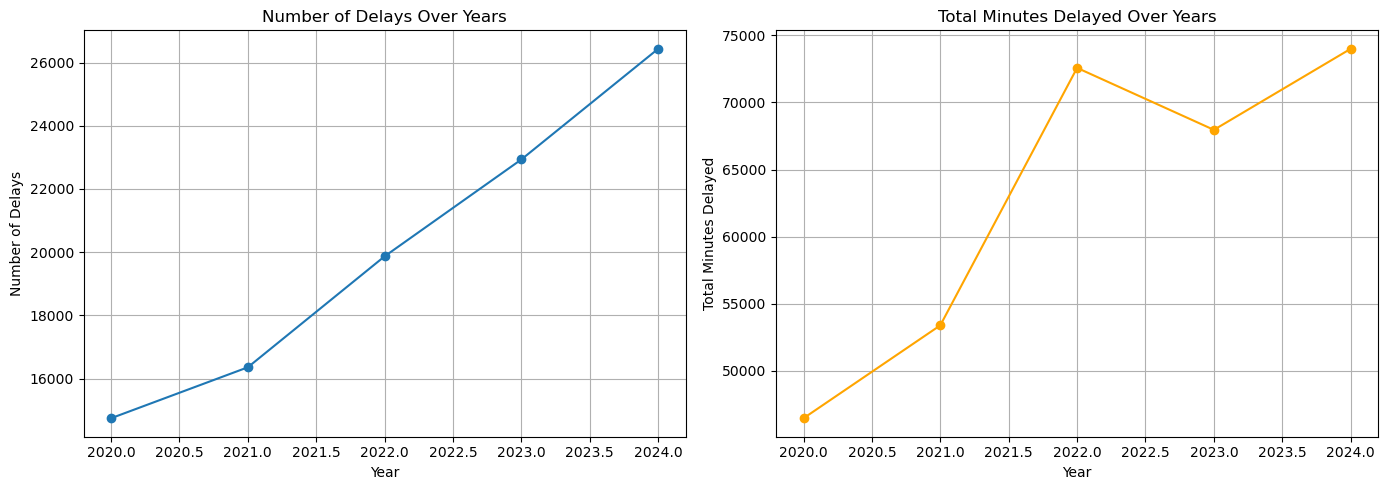

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))  # 1 row, 2 columns

# Plot 1: Number of delays by year
axs[0].plot(delays_per_year['Year'], delays_per_year['Number_of_Delays'], marker='o')
axs[0].set_title('Number of Delays Over Years')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Delays')
axs[0].grid(True)

# Plot 2: Total minutes delayed by year
axs[1].plot(minutes_delayed_per_year['Year'], minutes_delayed_per_year['Total_Minutes_Delayed'], marker='o', color='orange')
axs[1].set_title('Total Minutes Delayed Over Years')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Total Minutes Delayed')
axs[1].grid(True)

plt.tight_layout()
plt.show()

First, we examined number of delays and total delay minutes over the years.


In [45]:
delays_by_cause = df_delays.groupby('Category').size().reset_index(name='Number_of_Delays').sort_values(by='Number_of_Delays', ascending=False)
print(delays_by_cause)

minutes_by_cause = df_delays.groupby('Category')['Min Delay'].sum().reset_index(name='Total_Minutes_Delayed').sort_values(by='Total_Minutes_Delayed', ascending=False)
print(minutes_by_cause)

            Category  Number_of_Delays
1  Passenger-related             54004
2             System             46138
0       Fire/Weather               202
            Category  Total_Minutes_Delayed
1  Passenger-related                 159504
2             System                 152991
0       Fire/Weather                   1881


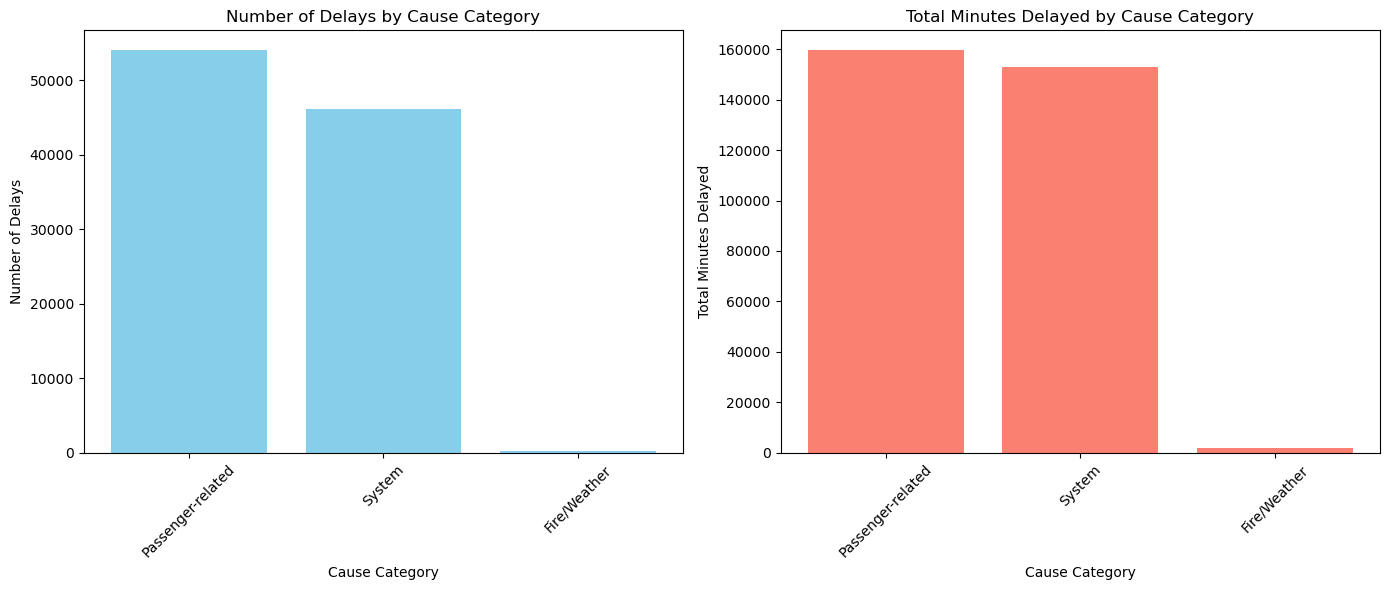

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))  # 1 row, 2 columns

# Bar chart 1: Number of delays by cause category
axs[0].bar(delays_by_cause['Category'], delays_by_cause['Number_of_Delays'], color='skyblue')
axs[0].set_title('Number of Delays by Cause Category')
axs[0].set_xlabel('Cause Category')
axs[0].set_ylabel('Number of Delays')
axs[0].tick_params(axis='x', rotation=45)

# Bar chart 2: Total minutes delayed by cause category
axs[1].bar(minutes_by_cause['Category'], minutes_by_cause['Total_Minutes_Delayed'], color='salmon')
axs[1].set_title('Total Minutes Delayed by Cause Category')
axs[1].set_xlabel('Cause Category')
axs[1].set_ylabel('Total Minutes Delayed')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Here, we looked at the number of delays and total minutes delayed by each Cause Category type (System, Passenger-related, Fire/Weather).


In [66]:
# Grouping by Year and Category to get number of delays
delays_by_year_cause = (df_delays.groupby(['Year', 'Category']).size().reset_index(name='Number_of_Delays'))
print(delays_by_year_cause)

# Grouping by Year and Category to get total minutes delayed
minutes_by_year_cause = (df_delays.groupby(['Year', 'Category'])['Min Delay'].sum().reset_index(name='Total_Minutes_Delayed'))
print(minutes_by_year_cause)

    Year           Category  Number_of_Delays
0   2020       Fire/Weather                40
1   2020  Passenger-related              6166
2   2020             System              8540
3   2021       Fire/Weather                29
4   2021  Passenger-related              7890
5   2021             System              8439
6   2022       Fire/Weather                57
7   2022  Passenger-related              9826
8   2022             System              9986
9   2023       Fire/Weather                36
10  2023  Passenger-related             14638
11  2023             System              8261
12  2024       Fire/Weather                40
13  2024  Passenger-related             15484
14  2024             System             10912
    Year           Category  Total_Minutes_Delayed
0   2020       Fire/Weather                    186
1   2020  Passenger-related                  18883
2   2020             System                  27390
3   2021       Fire/Weather                    144
4   2021 

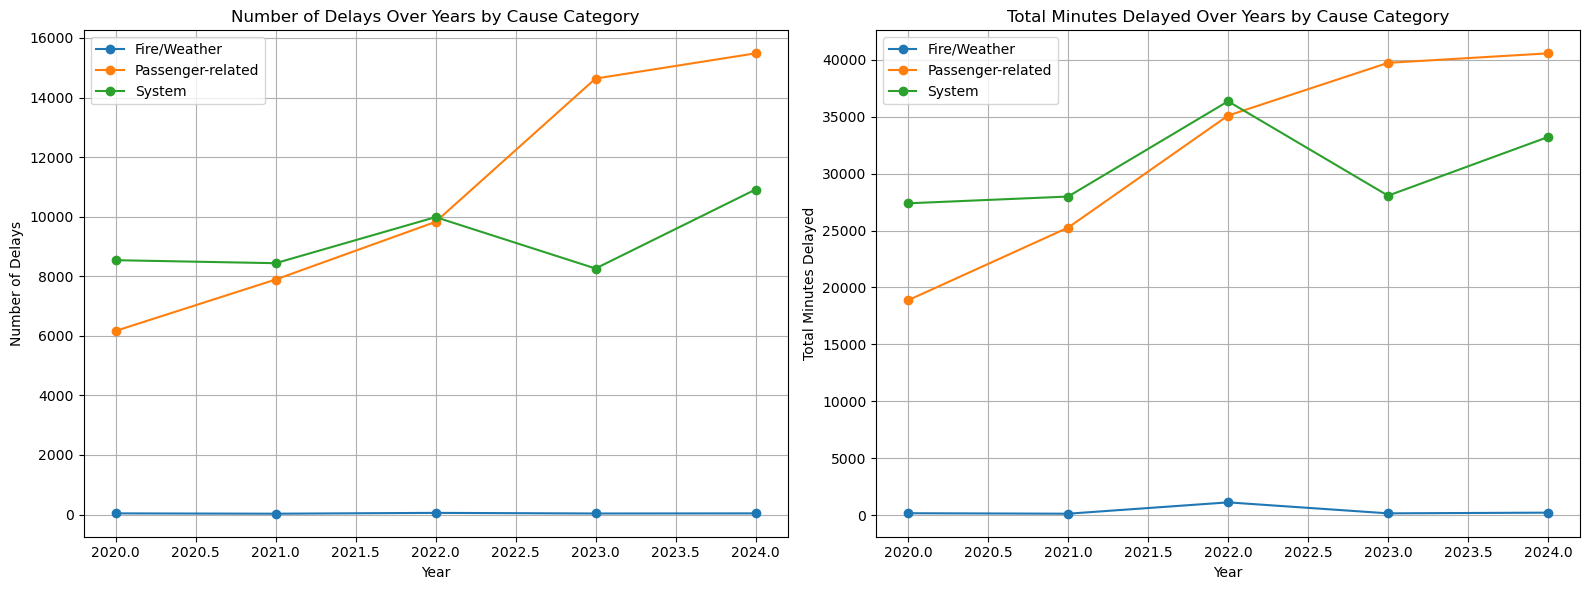

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(16,6), sharex=True)

# Number of delays over years by cause category
for cause in delays_by_year_cause['Category'].unique():
    subset = delays_by_year_cause[delays_by_year_cause['Category'] == cause]
    axs[0].plot(subset['Year'], subset['Number_of_Delays'], marker='o', label=cause)
axs[0].set_title('Number of Delays Over Years by Cause Category')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Delays')
axs[0].legend()
axs[0].grid(True)

# Total minutes delayed over years by cause category
for cause in minutes_by_year_cause['Category'].unique():
    subset = minutes_by_year_cause[minutes_by_year_cause['Category'] == cause]
    axs[1].plot(subset['Year'], subset['Total_Minutes_Delayed'], marker='o', label=cause)
axs[1].set_title('Total Minutes Delayed Over Years by Cause Category')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Total Minutes Delayed')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

We analysed the number of delays and total minutes delayed of the 3 Cause Categories over the 5 years. We noticed that Passenger-related Delays are dominant and has the most upward trend.

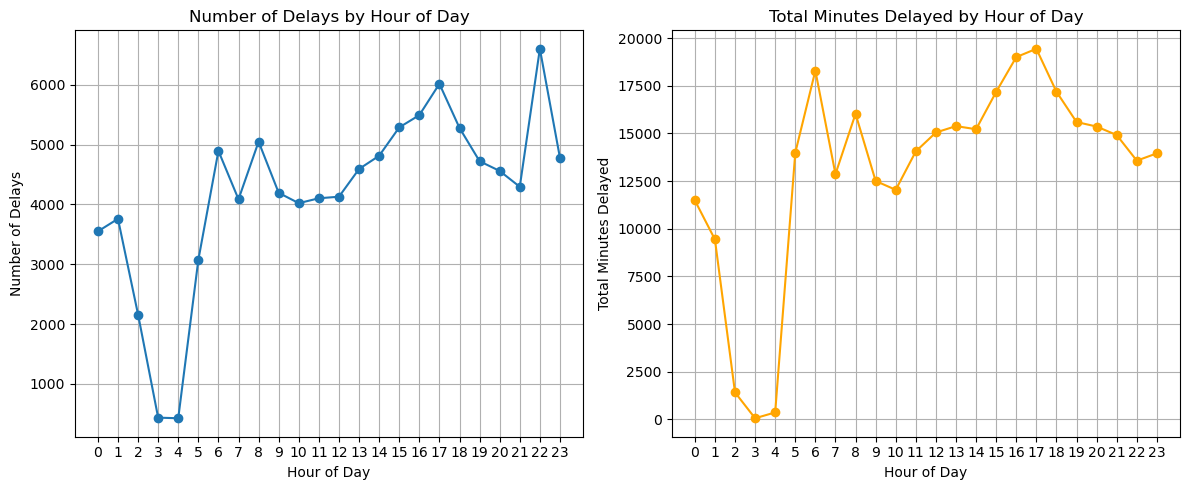

In [49]:
# Extract hour from Datetime
df_delays['Hour'] = df_delays['Datetime'].dt.hour

# Now group by Hour
delays_by_hour = df_delays.groupby('Hour').size().reset_index(name='Number_of_Delays')
minutes_by_hour = df_delays.groupby('Hour')['Min Delay'].sum().reset_index(name='Total_Minutes_Delayed')


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(delays_by_hour['Hour'], delays_by_hour['Number_of_Delays'], marker='o')
plt.title('Number of Delays by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Delays')
plt.xticks(range(0,24))
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(minutes_by_hour['Hour'], minutes_by_hour['Total_Minutes_Delayed'], marker='o', color='orange')
plt.title('Total Minutes Delayed by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Minutes Delayed')
plt.xticks(range(0,24))
plt.grid(True)

plt.tight_layout()
plt.show()

Here we looked at the number of delays and total minutes delayed by Hour of Day and see the same pattern almost.

DIVING DEEPER - Passenger-related Delays

In [51]:
cols_to_keep = ['Datetime', 'Day', 'Station', 'Code', 'Category', 'Min Delay']
df_passenger = df_delays.loc[df_delays['Category'] == 'Passenger-related', cols_to_keep].copy()
criminal_codes = ['SUAP', 'SUBT', 'SUPOL', 'SUROB', 'SUSA', 'SRAP', 'SRBT', 'SRSA', 'SUAE', 'SRAE', 'SUCOL']
disruptive_codes = ['SUDP', 'SUEAS', 'SUG', 'SRDP', 'SREAS', 'SUSP', 'SRSP', 'MRD', 'MUD', 'MUPAA', 'MRPAA', 'SRO', 'SUO', 'SUUT', 'SRUT']
medical_codes = ['MUI', 'MUIR', 'MUIRS', 'MUIS', 'MUPR1', 'MRPR1', 'MRUI', 'MRUIR'] 

def categorize_code(code):
    if code in criminal_codes:
        return 'Criminal'
    elif code in disruptive_codes:
        return 'Disruptive'
    elif code in medical_codes:
        return 'Medical'
    else:
        return 'Other'  # For codes that don't fit any category

df_passenger['Passenger_Category'] = df_passenger['Code'].apply(categorize_code)
df_passenger.head(5)

,Datetime,Day,Station,Code,Category,Min Delay,Passenger_Category
0,2020-01-01 01:18:00,Wednesday,KENNEDY SRT STATION,SRDP,Passenger-related,8,Disruptive
1,2020-01-01 01:27:00,Wednesday,SHEPPARD WEST STATION,MUI,Passenger-related,7,Medical
3,2020-01-01 03:54:00,Wednesday,KIPLING STATION,MUIS,Passenger-related,0,Medical
12,2020-01-01 14:12:00,Wednesday,SHEPPARD STATION,SUAP,Passenger-related,0,Criminal
13,2020-01-01 14:25:00,Wednesday,DUNDAS WEST STATION,MUIS,Passenger-related,0,Medical


In [52]:
# Check for missing (NaN) values in Passenger_Category
print(df_passenger['Passenger_Category'].isna().sum())

0


In [53]:
counts = df_passenger['Passenger_Category'].value_counts()
minutes = df_passenger.groupby('Passenger_Category')['Min Delay'].sum()

summary_df = pd.DataFrame({
    'Number_of_Delays': counts,
    'Minutes': minutes
}).reset_index().rename(columns={'index': 'Passenger_Category'})

print(summary_df)

  Passenger_Category  Number_of_Delays  Minutes
0           Criminal              4376    15625
1         Disruptive             30166    98566
2            Medical             19462    45313


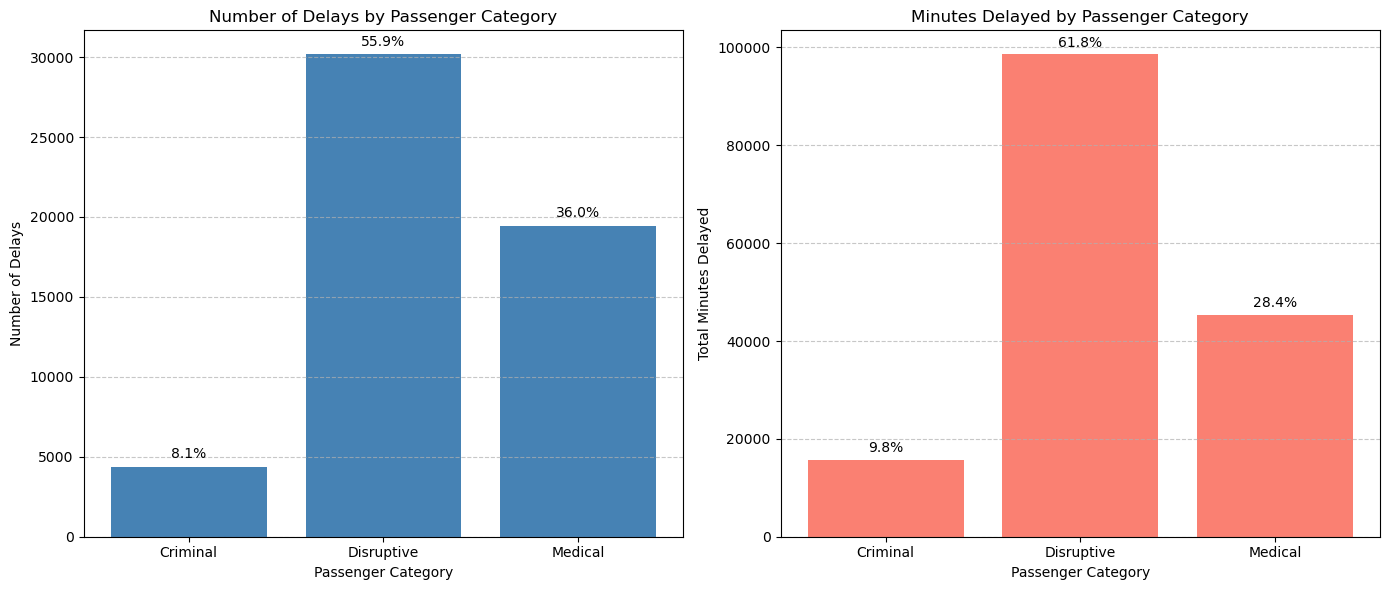

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Percentages for delays and minutes
delays_total = summary_df['Number_of_Delays'].sum()
minutes_total = summary_df['Minutes'].sum()
delays_pct = summary_df['Number_of_Delays'] / delays_total * 100
minutes_pct = summary_df['Minutes'] / minutes_total * 100

# Plot 1: Number of Delays
axes[0].bar(summary_df['Passenger_Category'], summary_df['Number_of_Delays'], color='steelblue')
axes[0].set_title('Number of Delays by Passenger Category')
axes[0].set_xlabel('Passenger Category')
axes[0].set_ylabel('Number of Delays')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(summary_df['Number_of_Delays']):
    axes[0].text(i, v + delays_total*0.01, f"{delays_pct[i]:.1f}%", ha='center')

# Plot 2: Minutes Delayed
axes[1].bar(summary_df['Passenger_Category'], summary_df['Minutes'], color='salmon')
axes[1].set_title('Minutes Delayed by Passenger Category')
axes[1].set_xlabel('Passenger Category')
axes[1].set_ylabel('Total Minutes Delayed')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(summary_df['Minutes']):
    axes[1].text(i, v + minutes_total*0.01, f"{minutes_pct[i]:.1f}%", ha='center')

plt.tight_layout()
plt.show()

Next, to better contextualize this, we look at the 3 sub-categories over the years in total delays and minutes delayed.

In [71]:
df_passenger['Year'] = pd.to_datetime(df_passenger['Datetime']).dt.year

delays_by_year = df_passenger.groupby(['Year', 'Passenger_Category']).size().reset_index(name='Number_of_Delays')
print(delays_by_year)

minutes_by_year = df_passenger.groupby(['Year', 'Passenger_Category'])['Min Delay'].sum().reset_index(name='Total_Minutes')
print(minutes_by_year)

    Year Passenger_Category  Number_of_Delays
0   2020           Criminal               618
1   2020         Disruptive              3128
2   2020            Medical              2420
3   2021           Criminal               675
4   2021         Disruptive              4294
5   2021            Medical              2921
6   2022           Criminal               901
7   2022         Disruptive              5285
8   2022            Medical              3640
9   2023           Criminal              1148
10  2023         Disruptive              8472
11  2023            Medical              5018
12  2024           Criminal              1034
13  2024         Disruptive              8987
14  2024            Medical              5463
    Year Passenger_Category  Total_Minutes
0   2020           Criminal           1375
1   2020         Disruptive           9942
2   2020            Medical           7566
3   2021           Criminal           3015
4   2021         Disruptive          14911
5   20

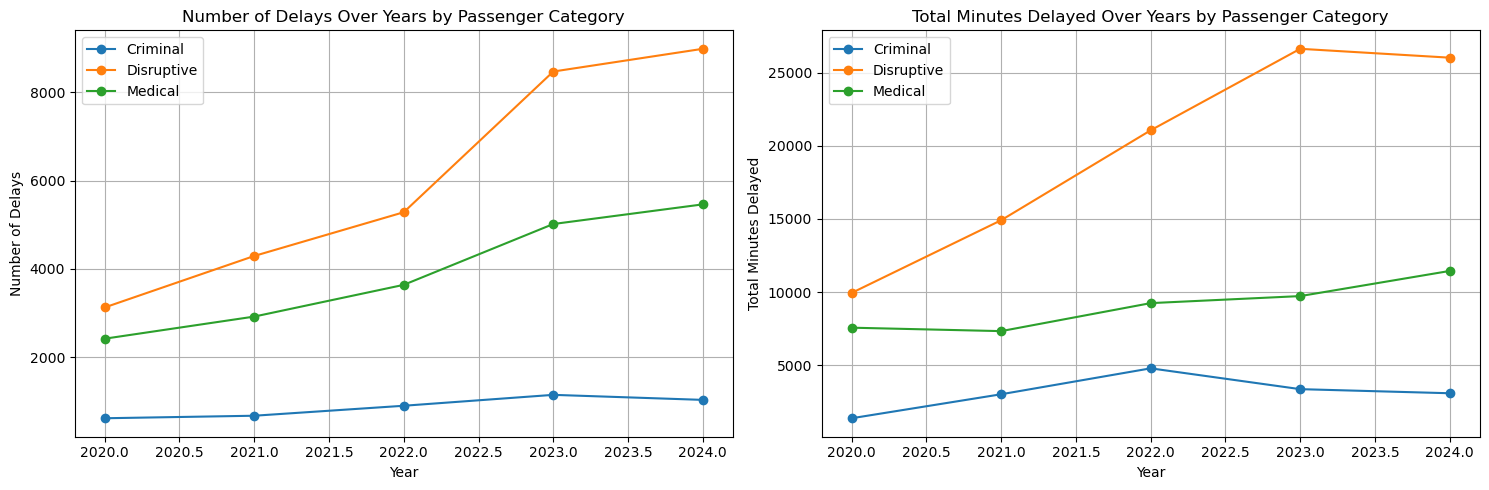

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True)

# Plot 1: Number of Delays
for category in delays_by_year['Passenger_Category'].unique():
    subset = delays_by_year[delays_by_year['Passenger_Category'] == category]
    axs[0].plot(subset['Year'], subset['Number_of_Delays'], marker='o', label=category)
axs[0].set_title('Number of Delays Over Years by Passenger Category')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Delays')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Total Minutes Delayed
for category in minutes_by_year['Passenger_Category'].unique():
    subset = minutes_by_year[minutes_by_year['Passenger_Category'] == category]
    axs[1].plot(subset['Year'], subset['Total_Minutes'], marker='o', label=category)
axs[1].set_title('Total Minutes Delayed Over Years by Passenger Category')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Total Minutes Delayed')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [72]:
df_passenger['Hour'] = df_passenger['Datetime'].dt.hour

delays_by_hour = df_passenger.groupby(['Hour', 'Passenger_Category']).size().reset_index(name='Number_of_Delays')
print(delays_by_hour)

minutes_by_hour = df_passenger.groupby(['Hour', 'Passenger_Category'])['Min Delay'].sum().reset_index(name='Total_Minutes')
print(minutes_by_hour)

    Hour Passenger_Category  Number_of_Delays
0      0           Criminal               173
1      0         Disruptive              1295
2      0            Medical              1014
3      1           Criminal               140
4      1         Disruptive              1331
..   ...                ...               ...
67    22         Disruptive              1642
68    22            Medical              1112
69    23           Criminal               234
70    23         Disruptive              1569
71    23            Medical              1149

[72 rows x 3 columns]
    Hour Passenger_Category  Total_Minutes
0      0           Criminal            704
1      0         Disruptive           4894
2      0            Medical           1551
3      1           Criminal            358
4      1         Disruptive           3943
..   ...                ...            ...
67    22         Disruptive           5458
68    22            Medical           2419
69    23           Criminal           

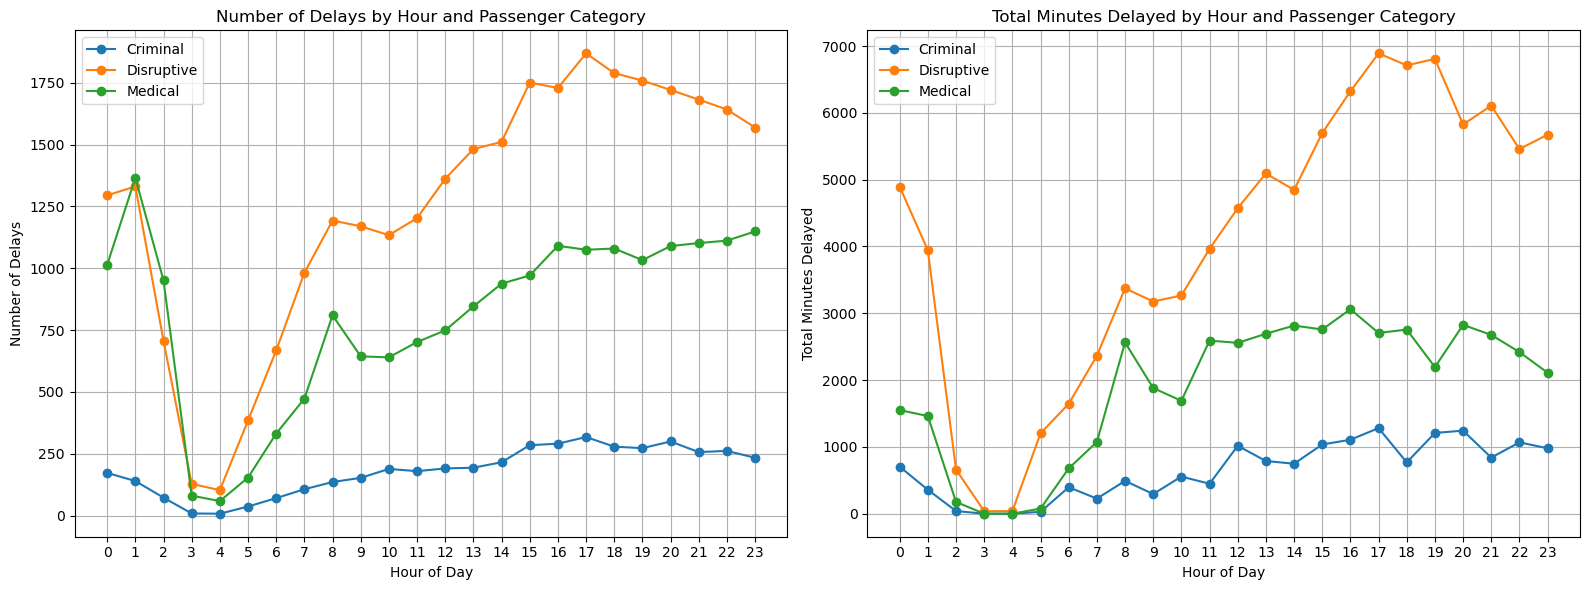

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(16,6), sharex=True)

# Plot 1: Number of Delays by Hour
for cat in delays_by_hour['Passenger_Category'].unique():
    subset = delays_by_hour[delays_by_hour['Passenger_Category'] == cat]
    axs[0].plot(subset['Hour'], subset['Number_of_Delays'], marker='o', label=cat)
axs[0].set_title('Number of Delays by Hour and Passenger Category')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Number of Delays')
axs[0].set_xticks(range(0,24))
axs[0].legend()
axs[0].grid(True)

# Plot 2: Total Minutes Delayed by Hour
for cat in minutes_by_hour['Passenger_Category'].unique():
    subset = minutes_by_hour[minutes_by_hour['Passenger_Category'] == cat]
    axs[1].plot(subset['Hour'], subset['Total_Minutes'], marker='o', label=cat)
axs[1].set_title('Total Minutes Delayed by Hour and Passenger Category')
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('Total Minutes Delayed')
axs[1].set_xticks(range(0,24))
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

We see clearly here that in our analysis over years then time of day the Disruptive Passenger subcategory dominates over the others


DIVING EVEN DEEPER - Disruptive Passenger-related Delays

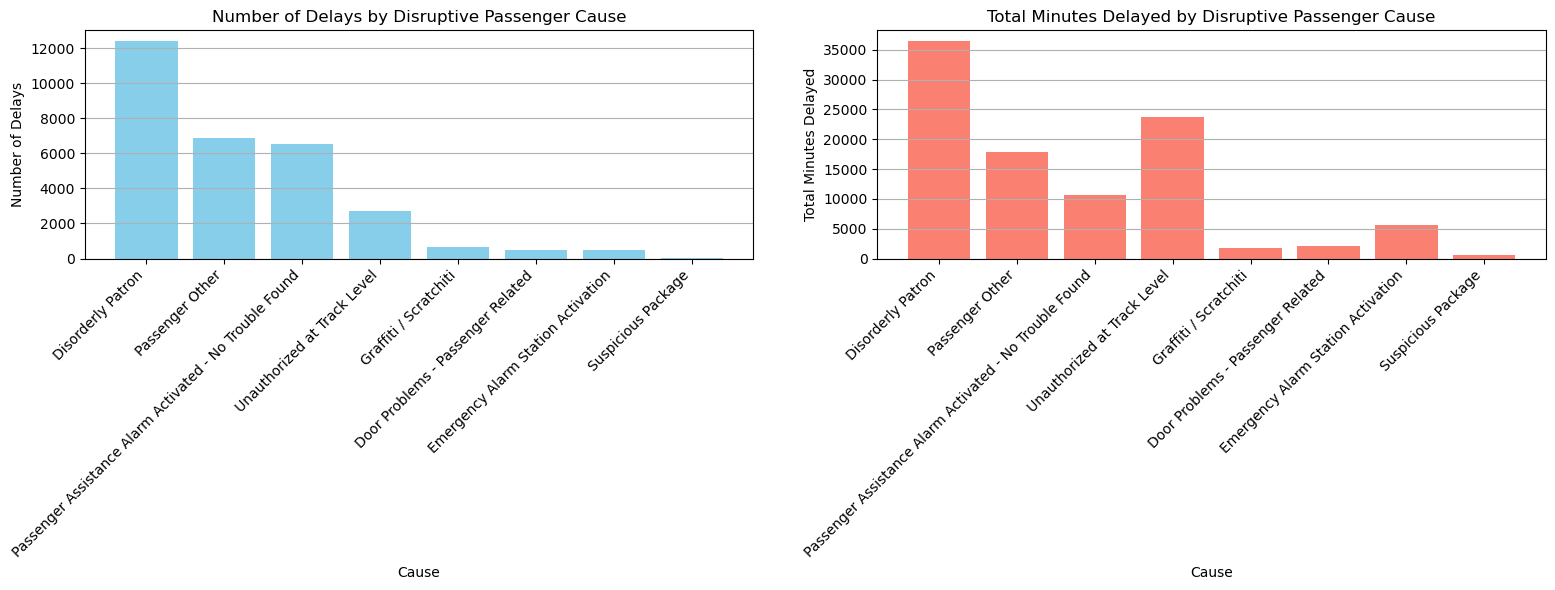

In [57]:
disruptive_df = df_passenger[df_passenger['Passenger_Category'] == 'Disruptive']

# Merge disruptive_df with code_cat_df on 'Code' to get the Cause descriptions
disruptive_with_cause = disruptive_df.merge(df_code_categories[['Code', 'Cause']], on='Code', how='left')

cause_summary = disruptive_with_cause.groupby('Cause').agg(
    Number_of_Delays=('Cause', 'size'),
    Total_Minutes_Delayed=('Min Delay', 'sum')
).reset_index()

# Sort by Number_of_Delays descending
cause_summary = cause_summary.sort_values(by='Number_of_Delays', ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(16,6))

# Plot 1: Number of delays
axs[0].bar(cause_summary['Cause'], cause_summary['Number_of_Delays'], color='skyblue')
axs[0].set_title('Number of Delays by Disruptive Passenger Cause')
axs[0].set_xlabel('Cause')
axs[0].set_ylabel('Number of Delays')
axs[0].set_xticks(range(len(cause_summary)))
axs[0].set_xticklabels(cause_summary['Cause'], rotation=45, ha='right', va='top')
axs[0].grid(axis='y')

# Plot 2: Total minutes delayed
axs[1].bar(cause_summary['Cause'], cause_summary['Total_Minutes_Delayed'], color='salmon')
axs[1].set_title('Total Minutes Delayed by Disruptive Passenger Cause')
axs[1].set_xlabel('Cause')
axs[1].set_ylabel('Total Minutes Delayed')
axs[1].set_xticks(range(len(cause_summary)))
axs[1].set_xticklabels(cause_summary['Cause'], rotation=45, ha='right', va='top')
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()

In [58]:
print(cause_summary[['Cause', 'Number_of_Delays', 'Total_Minutes_Delayed']].to_string(index=False))

                                                  Cause  Number_of_Delays  Total_Minutes_Delayed
                                      Disorderly Patron             12400                  36432
                                        Passenger Other              6878                  17829
Passenger Assistance Alarm Activated - No Trouble Found              6516                  10586
                            Unauthorized at Track Level              2691                  23747
                                  Graffiti / Scratchiti               683                   1719
                      Door Problems - Passenger Related               488                   2041
                     Emergency Alarm Station Activation               476                   5565
                                     Suspicious Package                34                    647


To get a better idea of the relationship, we ran a correlation matrix between the top 5 causes.

In [74]:
short_names = {
    'Disorderly Patron': 'Disorderly',
    'Emergency Alarm Station Activation': 'Emergency Alarm',
    'Passenger Assistance Alarm Activated - No Trouble Found': 'Passenger Alarm',
    'Passenger Other': 'Passenger Other',
    'Unauthorized at Track Level': 'Unauthorized Track'
}

pivoted_short = pivoted.rename(columns=short_names)

correlation_matrix_short = pivoted_short.corr()

print(correlation_matrix_short)

Cause               Disorderly  Emergency Alarm  Passenger Alarm  Passenger Other  Unauthorized Track
Cause                                                                                                
Disorderly            1.000000         0.342319         0.415268         0.519745            0.414716
Emergency Alarm       0.342319         1.000000         0.464584         0.577272            0.442726
Passenger Alarm       0.415268         0.464584         1.000000         0.747734            0.532646
Passenger Other       0.519745         0.577272         0.747734         1.000000            0.602516
Unauthorized Track    0.414716         0.442726         0.532646         0.602516            1.000000


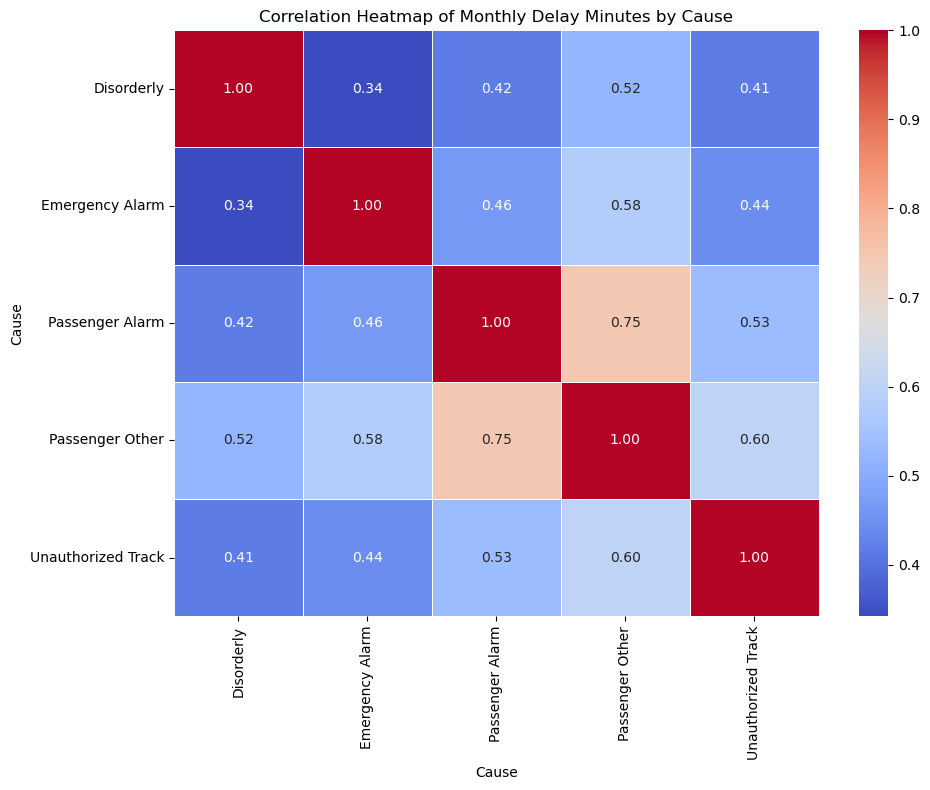

In [61]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_short, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Monthly Delay Minutes by Cause')
plt.tight_layout()
plt.show()

To better visualize the correlation, we made a scatter plot matrix of the data.

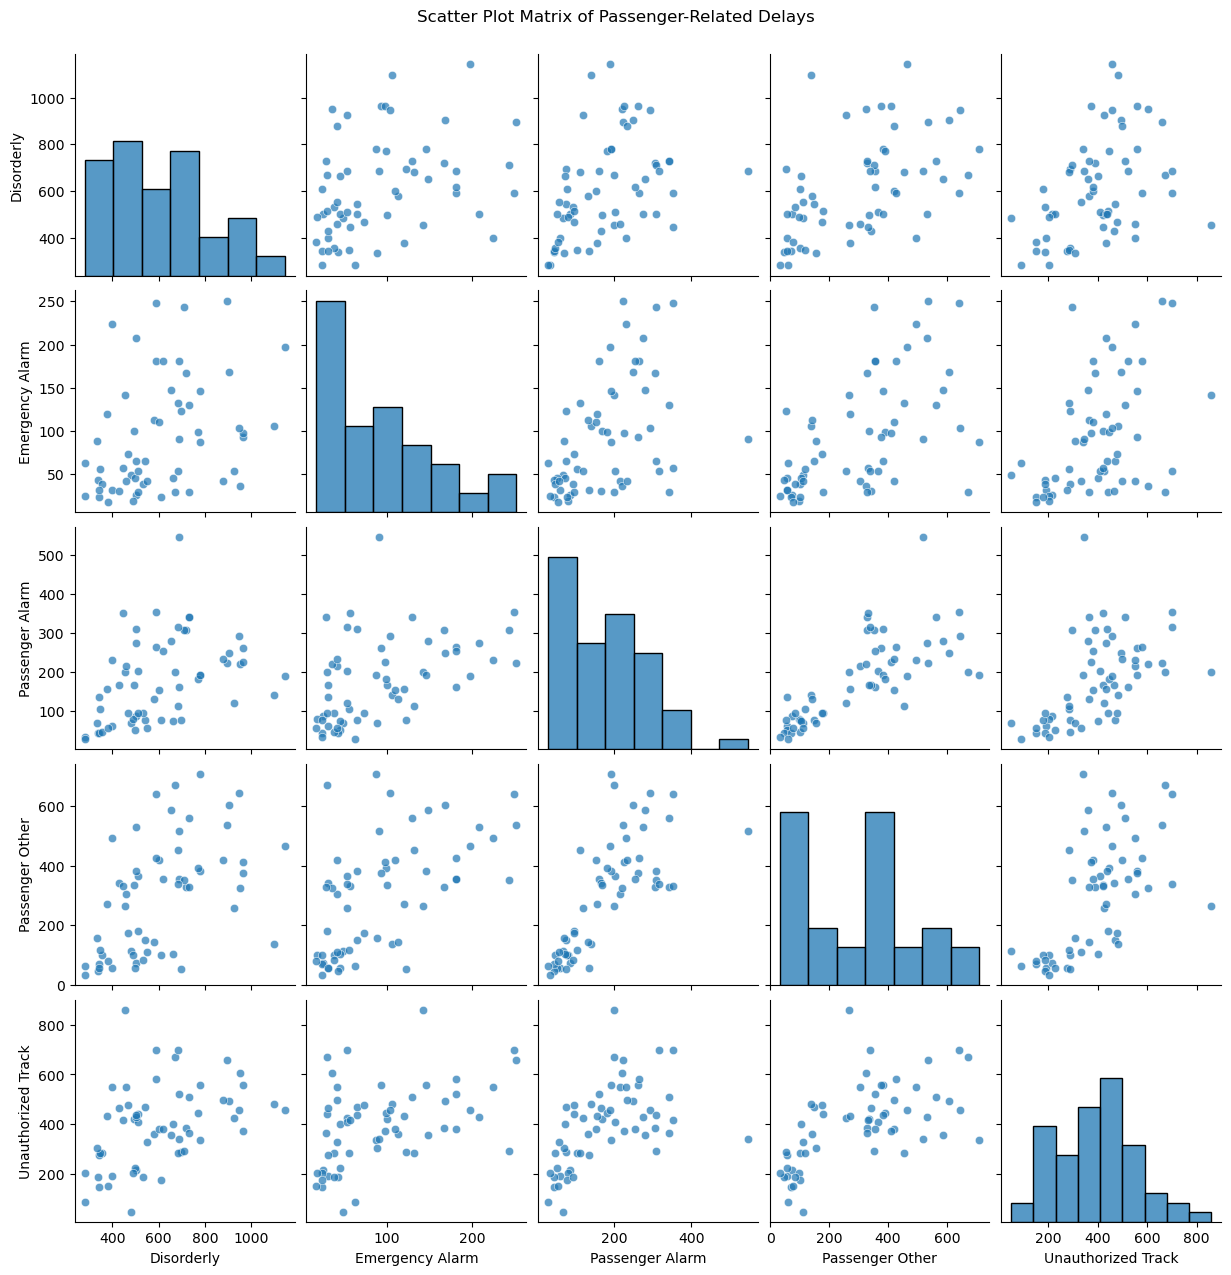

In [62]:
# Plot Scatter Matrix
sns.pairplot(pivoted_short, kind='scatter', plot_kws={'alpha': 0.7})
plt.suptitle("Scatter Plot Matrix of Passenger-Related Delays", y=1.02)
plt.show()

PREDICTIVE MODELLING

In this section, we tried building a predictive model using Random Forest for Cause categories using Datetime and Minutes delayed.

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

df_model = df_delays[['Datetime', 'Min Delay', 'Category']].copy()

df_model['Hour'] = df_model['Datetime'].dt.hour
df_model['DayOfWeek'] = df_model['Datetime'].dt.dayofweek
df_model['Month'] = df_model['Datetime'].dt.month

df_model = df_model.drop(columns=['Datetime'])

X = df_model.drop(columns=['Category'])
y = df_model['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


                   precision    recall  f1-score   support

     Fire/Weather       0.01      0.10      0.01        51
Passenger-related       0.65      0.64      0.65     13501
           System       0.60      0.56      0.58     11534

         accuracy                           0.61     25086
        macro avg       0.42      0.44      0.41     25086
     weighted avg       0.62      0.61      0.61     25086



Here we see that:
- Passenger-related delays have the highest F1-score (0.65), suggesting the model predicts these causes relatively well.
- System delays perform moderately well, with an F1-score of 0.58.
- Fire/Weather delays are very poorly predicted due to their small sample size (only 51 cases), leading to extremely low precision and recall.
- The overall accuracy of the model is ~61%, but this is heavily influenced by the large number of passenger-related delays.
- The macro average shows lower scores (~0.42 F1), indicating imbalance across categories. The model favors the majority class.

To further illustrate this, we included a confusion matrix.

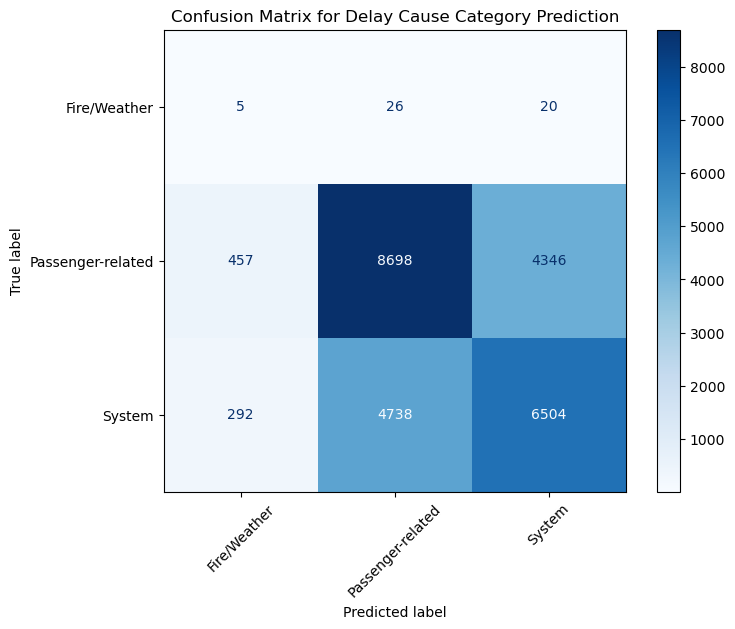

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix for Delay Cause Category Prediction')
plt.show()

We wanted to identify which features was most impacting the model...

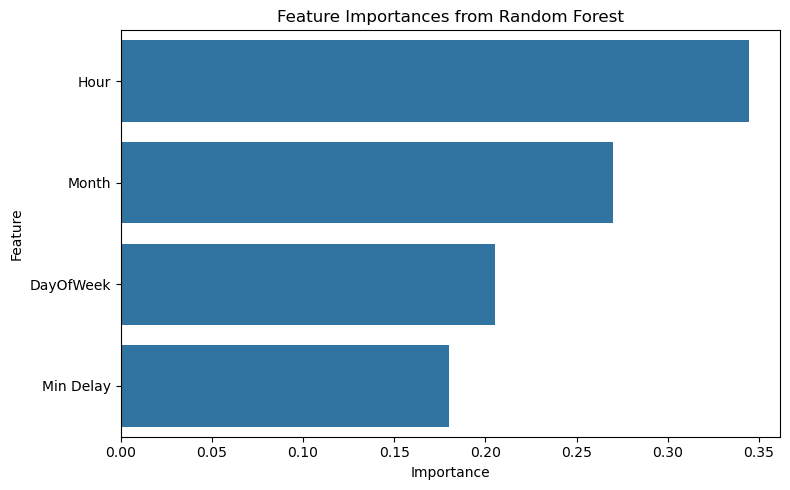

In [65]:
# Get feature importances from the model
importances = rf.feature_importances_

feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [49]:
# Import the Station Table for 
print(df_delays.head())

         Day                Station   Code  Min Delay            Datetime           Category        Station_NameRaw Station_NameClean Station_Cluster Station_Count
0  Wednesday    KENNEDY SRT STATION   SRDP          8 2020-01-01 01:18:00  Passenger-related    KENNEDY SRT STATION           Kennedy         Kennedy             1
1  Wednesday  SHEPPARD WEST STATION    MUI          7 2020-01-01 01:27:00  Passenger-related  SHEPPARD WEST STATION     Sheppard West   Sheppard West             1
2  Wednesday    MAIN STREET STATION   EUNT          3 2020-01-01 02:22:00             System    MAIN STREET STATION       Main Street     Main Street             1
3  Wednesday        KIPLING STATION   MUIS          0 2020-01-01 03:54:00  Passenger-related        KIPLING STATION           Kipling         Kipling             1
4  Wednesday          KEELE STATION  MUNOA          4 2020-01-01 08:07:00             System          KEELE STATION             Keele           Keele             1


In [75]:
#Look at the Delays levels by station in 
station_minutes_filtered_2024 = station_minutes[
    (station_minutes['Year'] == 2024) &
    (~station_minutes['Station_NameClean'].isin(["Other", "Multiple Stations", "OTher"]))
]


# Sum of delay minutes per Year, Station, and Type
station_minutes = (
    df_delays.groupby(['Year', 'Station_NameClean'], as_index=False)['Min Delay']
                 .sum()
                 .rename(columns={'Min Delay': 'Total_Minutes'})
)

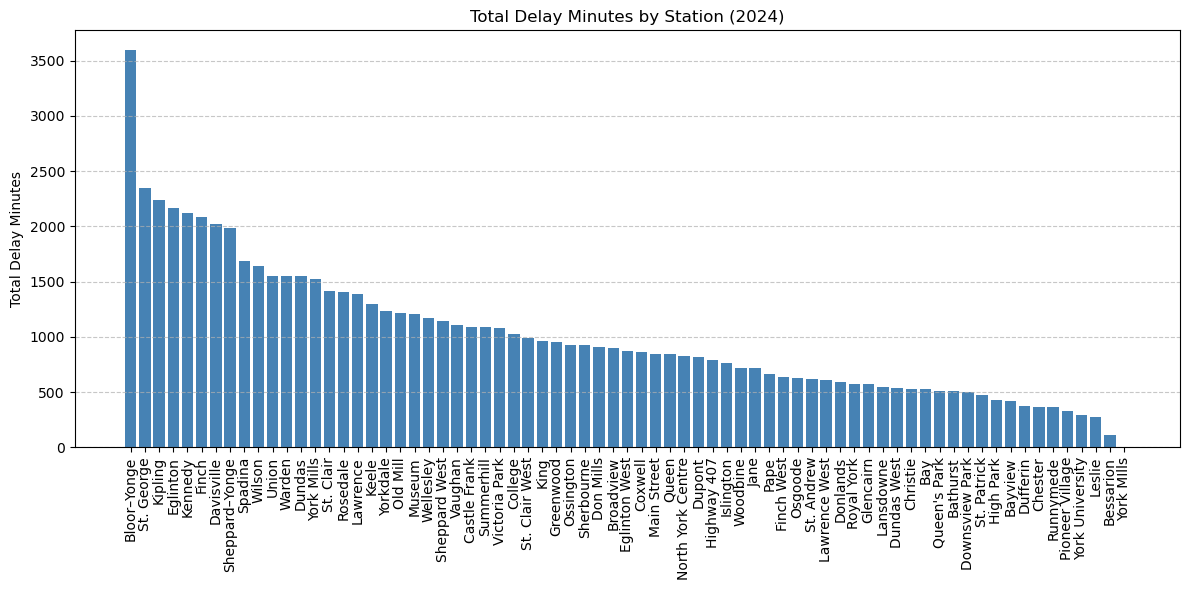

In [76]:
# Exclude "Other" and "Multiple Stations" and filter for 2024
station_minutes_filtered = station_minutes[
    (station_minutes['Year'] == 2024) &
    (~station_minutes['Station_NameClean'].isin(["Other", "Multiple Stations", "OTher"]))
]

# Total delay minutes per station
totals_2024 = (
    station_minutes_filtered_2024.groupby('Station_NameClean')['Total_Minutes']
    .sum()
    .reset_index()
    .sort_values('Total_Minutes', ascending=False)
)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(totals_2024['Station_NameClean'], totals_2024['Total_Minutes'], color='steelblue')
plt.title("Total Delay Minutes by Station (2024)")
plt.ylabel("Total Delay Minutes")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

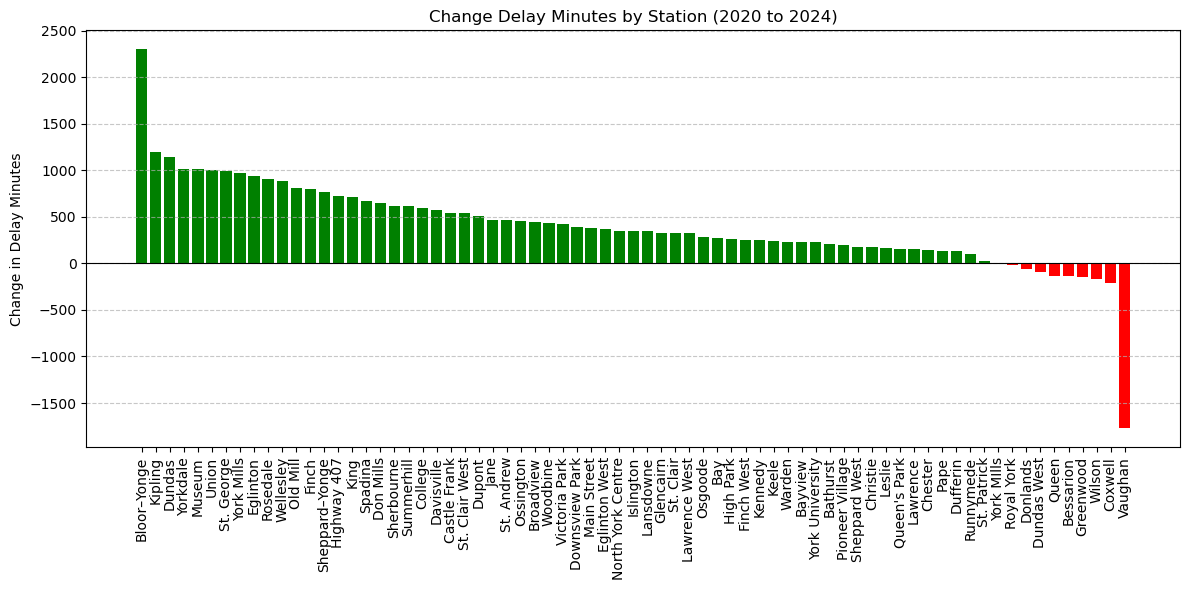

In [77]:
# Exclude "Other" and "Multiple Stations"
station_minutes_filtered = station_minutes[
    ~station_minutes['Station_NameClean'].isin(["Other", "Multiple Stations", "OTher"])
]

# Filter only for 2020 and 2024
change_df = station_minutes_filtered[station_minutes_filtered['Year'].isin([2020, 2024])]

# Pivot to get 2020 and 2024 in separate columns
change_pivot = change_df.pivot(
    index='Station_NameClean',
    columns='Year',
    values='Total_Minutes'
).fillna(0)

# Calculate change (2024 - 2020)
change_pivot['Change'] = change_pivot[2024] - change_pivot[2020]

# Sort by change
change_pivot_sorted = change_pivot.sort_values('Change', ascending=False)

# Plot all stations
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(change_pivot_sorted.index, change_pivot_sorted['Change'], color=['green' if x > 0 else 'red' for x in change_pivot_sorted['Change']])
plt.title("Change Delay Minutes by Station (2020 to 2024)")
plt.ylabel("Change in Delay Minutes")
plt.xticks(rotation=90)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

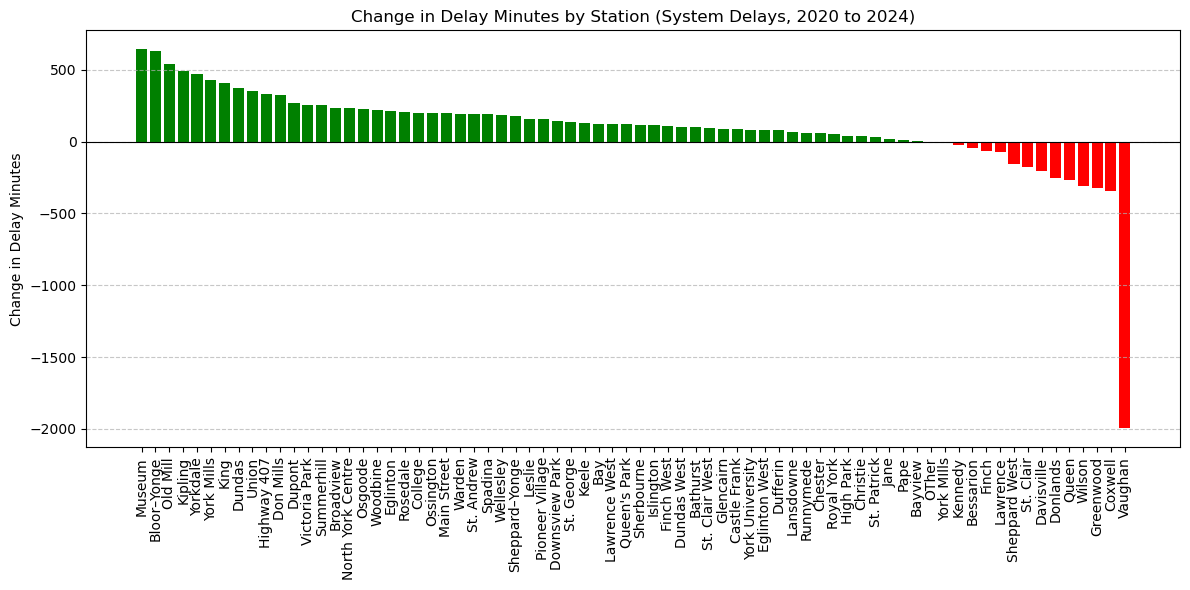

In [62]:
# Filter to exclude "Other" and "Multiple Stations"
station_minutes_filtered = df_delays[
    ~df_delays['Station_NameClean'].isin(["Other", "Multiple Stations"])
]

# Filter only 2020 and 2024
change_df = station_minutes_filtered[station_minutes_filtered['Year'].isin([2020, 2024])]

# ---- SYSTEM ----
system_df = change_df[change_df['Category'] == 'System']
system_pivot = system_df.groupby(['Station_NameClean', 'Year'], as_index=False)['Min Delay'].sum()
system_pivot = system_pivot.pivot(index='Station_NameClean', columns='Year', values='Min Delay').fillna(0)
system_pivot['Change'] = system_pivot[2024] - system_pivot[2020]
system_pivot_sorted = system_pivot.sort_values('Change', ascending=False)

plt.figure(figsize=(12,6))
plt.bar(system_pivot_sorted.index, system_pivot_sorted['Change'], 
        color=['green' if x > 0 else 'red' for x in system_pivot_sorted['Change']])
plt.title("Change in Delay Minutes by Station (System Delays, 2020 to 2024)")
plt.ylabel("Change in Delay Minutes")
plt.xticks(rotation=90)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

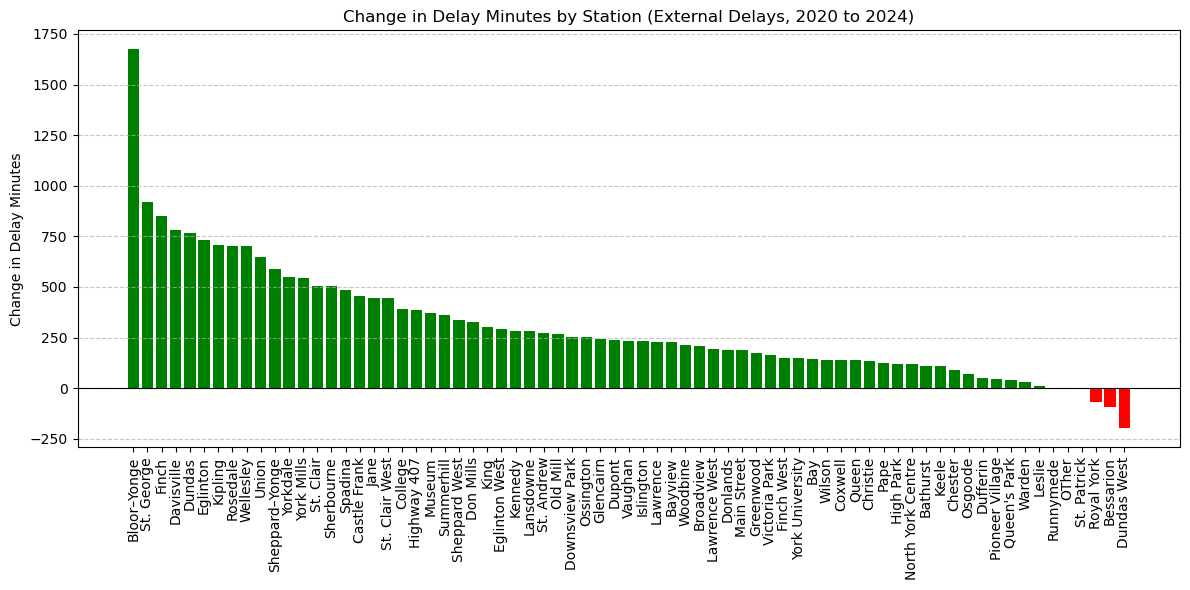

In [64]:
# ---- EXTERNAL ----
external_df = change_df[change_df['Category'] == 'Passenger-related']
external_pivot = external_df.groupby(['Station_NameClean', 'Year'], as_index=False)['Min Delay'].sum()
external_pivot = external_pivot.pivot(index='Station_NameClean', columns='Year', values='Min Delay').fillna(0)
external_pivot['Change'] = external_pivot[2024] - external_pivot[2020]
external_pivot_sorted = external_pivot.sort_values('Change', ascending=False)

plt.figure(figsize=(12,6))
plt.bar(external_pivot_sorted.index, external_pivot_sorted['Change'], 
        color=['green' if x > 0 else 'red' for x in external_pivot_sorted['Change']])
plt.title("Change in Delay Minutes by Station (External Delays, 2020 to 2024)")
plt.ylabel("Change in Delay Minutes")
plt.xticks(rotation=90)
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


That's all!